In [38]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
#!pip install pytesseract
# !sudo apt install tesseract-ocr

In [2]:
try:
 from PIL import Image
except ImportError:
 import Image
 
import cv2
import pytesseract

In [3]:
IMAGES_DIR_PATH="./random-cars-dataset/images"
ANNOTATIONS_DIR_PATH="./random-cars-dataset/annotations"

In [4]:
import os
images=[f for f in os.listdir(IMAGES_DIR_PATH)]
images.sort()

In [5]:
# import os
# xmls=[os.path.join(ANNOTATIONS_DIR_PATH,f) for f in os.listdir(ANNOTATIONS_DIR_PATH)]
# xmls.sort()

index: 167
image: ./random-cars-dataset/images/Cars167.png
width: 500, height: 400


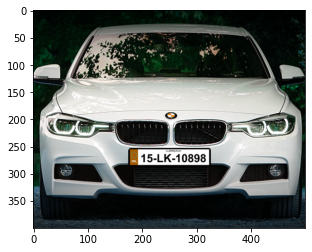

In [80]:
from random import randint
index=randint(0,len(images)-1)
img_path=f'{IMAGES_DIR_PATH}/Cars{index}.png'

print(f"index: {index}")
print(f"image: {img_path}")

im = Image.open(img_path)
width,height= im.size

print(f"width: {width}, height: {height}")

import cv2
img=cv2.imread(img_path)
plt.imshow(img)

In [18]:
# img.shape

#To view the image using opencv
# cv2.imshow("image0",img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [13]:
# import xml.etree.ElementTree as ET


# root=ET.parse(xmls[index]).getroot()

# ob=root.find('object')

# xmin=int(ob.find('bndbox/xmin').text)
# ymin=int(ob.find('bndbox/ymin').text)
# xmax=int(ob.find('bndbox/xmax').text)
# ymax=int(ob.find('bndbox/ymax').text)

# box=[xmin, ymin, xmax, ymax]




C:\Users\HP\Desktop\ML\ANPR\yolov5
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='', exist_ok=True, img_size=640, iou_thres=0.45, name='exp', nosave=False, project='runs/detect', save_conf=False, save_txt=True, source='.././random-cars-dataset/images/Cars167.png', update=False, view_img=False, weights=['./runs/train/exp2/weights/best.pt'])
Fusing layers... 
image 1/1 C:\Users\HP\Desktop\ML\ANPR\yolov5\..\random-cars-dataset\images\Cars167.png: 512x640 1 license_plate, Done. (0.256s)
Results saved to runs\detect\exp
10 labels saved to runs\detect\exp\labels
Done. (0.285s)
181 251 327 299
C:\Users\HP\Desktop\ML\ANPR


YOLOv5  cc68ec2 torch 1.8.1+cpu CPU

Model Summary: 224 layers, 7053910 parameters, 0 gradients, 16.3 GFLOPS


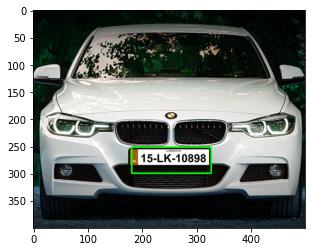

In [81]:
%cd yolov5
!python detect.py --weights ./runs/train/exp2/weights/best.pt --source ../{img_path} --save-txt --exist-ok

#get yolov5 label and get the bounding box
label_file=open(f'./runs/detect/exp/labels/Cars{index}.txt')
s=label_file.readline().replace('\n','').split(' ')
s=[ float(i) for i in s]

bottom_x=((2*s[1]+s[3])/2)
top_x=bottom_x-s[3]

bottom_y=((2*s[2]+s[4])/2)
top_y=bottom_y-s[4]

top_x=int(top_x*width)
bottom_x=int(bottom_x*width)

top_y=int(top_y*height)
bottom_y=int(bottom_y*height)

print(f'{top_x} {top_y} {bottom_x} {bottom_y}')

img=cv2.rectangle(img,(top_x,top_y),(bottom_x,bottom_y),(0,255,0),2)
plt.imshow(img)

%cd ..

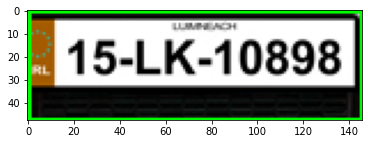

In [82]:
img_crop=img[top_y:bottom_y,top_x:bottom_x]

plt.imshow(img_crop)

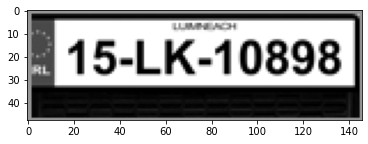

In [83]:
img_gray=cv2.cvtColor(img_crop, cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray,cmap="gray")

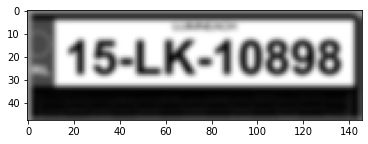

In [85]:
# img_blur = cv2.GaussianBlur(img_gray, (5,5), 0)
# plt.imshow(img_blur,cmap="gray")

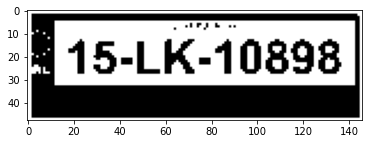

In [87]:
img_bw=cv2.threshold(img_gray, 0, 255, cv2.THRESH_OTSU)[1]
plt.imshow(img_bw, cmap="gray")

In [88]:
contours,_=cv2.findContours(img_bw, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])

print(f"No of contours: {len(contours)}")

No of contours: 36


In [89]:
#utility function to convert number(0-35) to label(0-9, A-Z)
def to_label(n):
    if n<=9:
        return str(n)
    
    return chr(n-10+ord('A'))

In [90]:
# from pytesseract import image_to_string as im_2_st
from pytesseract import image_to_string
from itertools import chain
# from google.colab.patches import cv2_imshow



#loading recognition model
from keras.models import load_model
char_recog_model=load_model('char_recog_model.h5')


answer=""
index=0

#iterating over contours
for cont in contours:
    x,y,w,h=cv2.boundingRect(cont)
    
    #w: width of character
    #h height of character
    
    img_h,img_w=img_bw.shape
    
    #.......removing noise........#
    width_of_plate=s[3]*width
    height_of_plate=s[4]*height
    
    if (width_of_plate)/w<2:
        continue
        
    if(height_of_plate)/h>3:
        continue
    #.............................#
        
    roi=img_bw[y:y+h,x:x+w]
    
    #adding padding
    #roi=cv2.copyMakeBorder(roi,5,5,5,5,cv2.BORDER_CONSTANT,value=[0,0,0])
    
    #resizing image to model input format (28x28)
    roi=cv2.resize(roi, (28, 28))
    
    #saving image
    cv2.imwrite(f'./output/{index}.jpg',roi)
    
    #flattening image
    roi=list(chain.from_iterable(roi))
    
    #predicting label using model
    pred=char_recog_model.predict(np.array([roi]))
    
    #finding label mith max probability
    pred=np.argmax(pred)
    
    answer+=to_label(pred)
    
    index+=1

    
print(f"Detected License Plate Number: {answer}")

Detected License Plate Number: 15LK10898
